# Automatic Detection of Hate Speech and Offensive Content

In [85]:
# convert html character entities to unicode (ex: &copy; -> ©)
from html import unescape

import matplotlib.pyplot as plt
import neattext as nt  # needed for text cleaning
import numpy as np  # array processing
import pandas as pd  # data analysis
import tensorflow as tf  # we'll be using keras near the end of the notebook
from better_profanity import profanity  # censor offensive words
from nltk.tokenize import TweetTokenizer  # tokenizer
# create a bag of words representation of the text data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# scoring metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split # for splitting dataset into training and test sets

# set the seed to get reproducible results
SEED_NUM = 24
np.random.seed(SEED_NUM)
tf.random.set_seed(SEED_NUM)

# increase pandas column widths
pd.options.display.max_colwidth = 200

# data paths
DAVIDSON_DATA_PATH = './data/davidson/labeled_data.txt'
HURTLEX_DATA_PATH = './data/hurtlex_EN.tsv'
GLOVE_TWITTER_EMBEDDINGS_PATH = './models/embeddings/glove-twitter-200.txt'

## Introduction 

In this assignment I will go through the steps of building a classifier that can detect hateful and offensive content in English.

One of the reasons I chose to work on this topic is because I feel there is not enough being done to curb the rampant online harassment that people have to deal with on social media. Hate speech, racial slurs, offensive content, threats of violence, and unwanted sexual comments are against the terms of service of all major social media websites, and yet in some communities they are as common as cat gifs. 

Some reasons why people get harassed or threatened online are because of their gender, race, religion, sexual orientation, or political views. Of course, none of these are good reasons as to why you should be hostile towards someone, but many people do not realize this. The majority of online harassment occurs on social media websites [$^{1}$](https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/), so the responsibility falls on these large tech companies to look after their users' safety and well-being. Unfortunately, these companies are not doing enough.

Let's look at how Facebook moderates its content. Most of Facebook's content moderation team does not work directly for Facebook as they are outsourced, and there are not that many of them. [$^{3}$](https://www.forbes.com/sites/johnkoetsier/2020/06/09/300000-facebook-content-moderation-mistakes-daily-report-says/?sh=2e15774d54d0) Facebook uses a hybrid system to moderate their content. Content is input into an A.I. model and will be flagged for review if the model detects any content violating the platform's terms of service. (Users can also flag content for review) This model does prevent a lot of harmful content from being seen, but it clearly could be implemented better based on the amount of users experiencing harassment on the platform. This model is also used to filter spam, fake news, and adult content, but of course this type of content is still very common on Facebook. [$^{4}$](https://www.forbes.com/sites/traversmark/2020/03/21/facebook-spreads-fake-news-faster-than-any-other-social-website-according-to-new-research/) Given the low number of human moderators working with Facebook, only 15,000 for over 2.9 billion monthly active users, [$^{3}$](https://www.forbes.com/sites/johnkoetsier/2020/06/09/300000-facebook-content-moderation-mistakes-daily-report-says/?sh=2e15774d54d0) [$^{2}$](https://www.statista.com/statistics/264810/number-of-monthly-active-facebook-users-worldwide/) there is a huge burden on Facebook's classifier to correctly flag objectionable content.

I will be working with English language data in this notebook but the same techniques can be applied to data in other languages. While there is hate speech and misinformation present in English language communities on social media, the problem is amplified in parts of the world that have pre-existing racial or religious tensions between people. The textbook example of this is Facebook's wildly irresponsible expansion into Myanmar. Over there Facebook was used to spread hatred and incite violence against the Rohingya people, a Muslim minority group. Fake news and hate speech, targeted at the Rohingya people, spread like wildfire on Facebook's platform, often resulting in real-world violence against them.[$^{6}$](https://apnews.com/article/technology-business-middle-east-religion-europe-a38da3ccd40ffae7e4caa450c374f796) Facebook has failed on every step of the way to moderate the content being posted in Myanmar and the results were unfortunately tragic and completely avoidable.

**Note**: Due to the nature of this topic and the dataset used, this notebook will contain examples of language that could be considered to be offensive or vulgar by the reader. I have tried to minimize the amount of objectionable content by limiting the amount of times I preview the data and by using a python module that censors profanity.

## Objectives

In this assignment I will show how AI and natural language processing can be used for social good by building multiple versions of a hateful content classifier, with each version being more sophisticated than the next. 

My goals with this assignment is to tackle an interesting, yet somewhat niche problem and to hopefully create a product that can be put to good use. When I say that this is a niche problem I do not mean that online harassment is a rare phenomenon, I am just commenting on the fact that while researching this topic I did not find a lot of community or commercial interest in AI-related solutions to this problem. I did however, find multiple academic papers and datasets that try to tackle this issue. In particular, I find that the work being done by the Hate-Alert group in IIT Kharagpur [$^{5}$](https://hate-alert.github.io/) to be very promising. 

I suspect that corporations are not interested because there is not much financial incentive for them to develop a solution to this problem, and any solution would probably bring up issues of privacy and surveillance that these companies would like to avoid. The lack of a community-driven or open-source solution to this issue is disappointing. The technology obviously exists since Twitter, Facebook, and YouTube all have classifiers that can detect offensive content, and in this same notebook I will show you how you can build one of these yourself (it's not very hard).

I can think of several use cases for a classifier like this:

1. It can be used to help people moderate communities.

2. It can be used to enforce the terms of service of a social media website or any website that has a large amount of user-generated content.

3. It can be part of a browser extension that blocks hateful content from social media sites in a similar way that AdBlock blocks ads. (You can even give it a fun name like TrollBlock).

4. It can be used to pre-screen DMs before you get a chance to see them. This can be helpful for some people, particularly public figures and content creators, but of course it brings up some privacy concerns which I will not address here.

## Dataset
### Hate Speech and Offensive Language Dataset by Davidson et. al

This dataset was developed by researchers at Cornell University, who wanted to improve traditional hate speech classifiers which relied too much on offensive language detection and could not differentiate between the use of an offensive term and actual hate speech. This dataset makes a distinction between text that contains hate speech and offensive content, which should make hate speech classifiers more accurate when it comes to classifying text that is offensive yet is not considered hate speech. I will be using this dataset to identify instances of English language hate speech and offensive content. I chose this dataset because of its direct connection to the topic, and because it is interesting.

This dataset contains around 24.8k English language tweets that can contain either hate speech or offensive language, and there are also tweets that contain neither. The classification of these tweets has been crowdsourced by a platform called CrowdFlower which is a data collection agency that seems to have been renamed to Figure Eight, and then acquired by an Australian data company named Appen in recent years.

Since the line between hate speech and offensive language is not very well defined, and since not everyone agrees on what is offensive or not, datasets like these will always have a degree of bias or subjectivity. It seems that researchers are aware of this issue because I have noticed that some hate speech datasets have multiple people classifying each example. In this dataset each example is classfied by a group of 3 to 9 people. This 'wisdom of the crowd' approach will help with the inherent bias present in this domain, but of course it will not eliminate it.


The columns of interest in this dataset are:

| Name               | Type                  | Description                                                  |
| ------------------ | --------------------- | ------------------------------------------------------------ |
| count              | Integer               | Number of people who classified this tweet as containing hate speech, offensive language, or neither |
| hate_speech        | Integer               | How many people classified this tweet as containing hate speech |
| offensive_language | Integer               | How many people classified this tweet as containing offensive language |
| neither            | Integer               | How many people classified this tweet as neither containing hate speech or offensive language |
| class              | Integer (Categorical) | This number represents the what the majority of people classified this tweet as.<br/>      0 = hate speech<br/>      1 = offensive language<br/>      2 = neither |
| tweet              | Text                  | The text content of the tweet                                |


# Evaluation Methodology 

#### Checking for Class Imbalance in the Davidson Dataset

The choice of evaluation metrics will be fueled by whether or not there is a class imbalance included in this dataset. We can check this easily with pandas, and graph the results. 

In [2]:
# Read the dataset with pandas
davidson_preview = pd.read_csv(DAVIDSON_DATA_PATH, index_col=0)

In [3]:
# Get the count of each class, and rename the index for clarity
class_count = davidson_preview['class'].value_counts().rename(index={
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
})

class_count

Offensive Language    19190
Neither                4163
Hate Speech            1430
Name: class, dtype: int64

In [4]:
# Class count as percentages
(class_count / class_count.sum()).round(3)

Offensive Language    0.774
Neither               0.168
Hate Speech           0.058
Name: class, dtype: float64

So, we can see that this is a very imbalanced dataset with around 77% of the tweets containing offensive language, 17% containing non-offensive language, and only 6% containing hate speech.

Let's make this class imbalance clearer by plotting it.

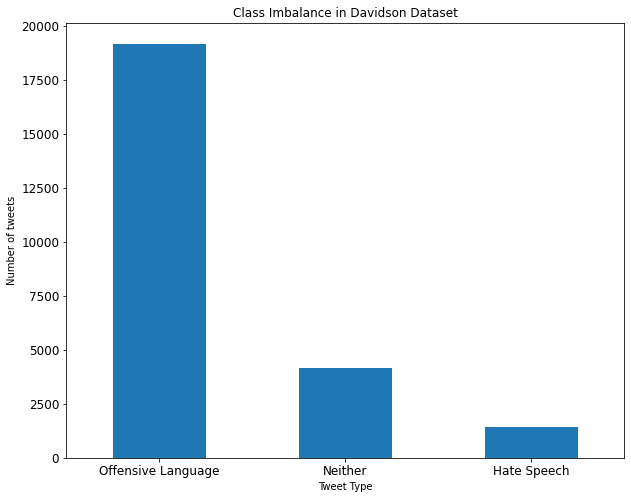

In [5]:
# Increase figure size
plt.figure(figsize=(10, 8))

# Use the built-in plotting functionality of pandas to create a bar plot
class_count.plot(kind='bar',
                 rot=0,
                 xlabel='Tweet Type',
                 ylabel='Number of tweets',
                 title='Class Imbalance in Davidson Dataset',
                 fontsize=12);

### Metrics for Davidson Dataset

Because of the massive class imbalance in this dataset we will not be focusing on accuracy as a metric. A high accuracy score on an imbalanced data is misleading, as you will see in the performance baseline section. We will be looking at the precision and recall scores of our classifiers when evaluating them. For this particular application I believe that having a high recall score is more important than a high precision score. Classifiers like these are usually used to flag user submitted content for review by a moderation team, who will decide whether the content is against the terms of service of the platform or not. Having a high recall is important to avoid potentially harmful content from appearing on the platform, whereas having a low precision will make the job of the content moderation team more difficult. We will mainly be looking at the F1 score, which is just the harmonic mean of the precision and recall scores. To get a high F1 score you will need to have high precision and recall scores.

This dataset is also a multi-class dataset so we will need to take into account the averaged scores of the precision, recall, and F1 scores. For example, to calculate the F1 score of a classifier on this dataset we will need to calculate the F1 score for each class and then average the results. In practice, scikit-learn will just do that for us.

#### Scikit-Learn Averaging Strategies

Scikit-learn has different methods for calculating precision, recall, and F1 scores for multi-class problems and since these different methods could give you wildly different results it is worth talking about them. The three strategies I considered for problem are `micro`, `macro`, and `weighted`.

##### Micro

The `micro` strategy simply sums up the total amount of true positives, false positives, and false negatives when calculating precision and recall. It does not calculate the precision and recall scores for each class, and it does not take class imbalance into account.

##### Macro

The `macro` strategy calculates the precision and recall scores for each class and the resulting precision/recall score is the average of precision/recall score of each class. It does not take into account class imbalance.

##### Weighted

The `weighted` strategy is similar to the `macro` strategy but it takes class imbalance into account by giving a weight to each class based on how represented that class is in the test data.

I mainly looked at the `macro` precision/recall/F1 score of the classifiers I built in this notebook because even though I am working with an imbalanced dataset, every class has equal importance. I want my classifier to be able to identify instances of each class correctly, but if I chose the `weighted` strategy I would be able to get a high F1 score by performing poorly in the hate speech class, but doing very well in the other two classes.

# Implementation 

## Baseline Performance

We will be using two classifiers as baselines for the Davidson dataset, with one of them being more realistic than the other.
### Dummy Classifier

This classifier will classify every example as being offensive. It will have a surprisingly high accuracy score because of the class imbalance, but of course it is not a good classifier.

In [6]:
from sklearn.dummy import DummyClassifier

# The sklearn DummyClassifier class makes it possible to create dumb classifiers like this
dummy = DummyClassifier(strategy='constant', constant=1)

In [7]:
# There's no need to split the dataset into training and test sets
X = davidson_preview['tweet']
y = davidson_preview['class']

In [8]:
dummy.fit(X, y)  # does nothing

# This will just be an array of 1s
dummy_preds = dummy.predict(X)

In [9]:
# Preview of the 'predicitions'
dummy_preds[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

We'll now write a function that we will use throughout this notebook to evaluate our classifiers.

In [10]:
def evaluate_classifier(classifier, X, y, print_results=True, averaging_strategy="macro"):
    """
    Computes several metrics to evaluate the performance of a scikit-learn classifier
    The metrics calculated are [Accuracy, Precision, Recall, F1 Score]

    Parameters
    ----------
    classifier : scikit-learn classifier
        The classifier used to generate predictions on the test set
        
    X : numpy array or pandas DataFrame
        The test set
        
    y : numpy array or pandas Series
        The labels for the test set
        
    print_results : bool, optional
        Whether to print the metrics calculated 
        or to return them as a tuple, by default True
        
    averaging_strategy : str, optional
        What averaging strategy to use for 
        multi-class problems, by default "macro"

    Returns
    -------
    None or tuple
        Returns nothing if print_results is True,
        else returns a tuple of the metrics calculated
    """
    preds = classifier.predict(X)

    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds, average='macro')
    recall = recall_score(y, preds, average='macro')
    f1 = f1_score(y, preds, average='macro')

    if print_results:
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 Score: ", f1)
    else:
        return accuracy, precision, recall, f1

In [11]:
evaluate_classifier(dummy, X, y)

Accuracy:  0.7743211072105879
Precision:  0.2581070357368626
Recall:  0.3333333333333333
F1 Score:  0.29093610473093334


C:\ProgramData\Miniconda3\envs\nlp-mid\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So we get a high accuracy, but very poor precision, recall, and F1 scores.

Let us see what a more realistic baseline looks like.

### Keyword Detection

One of the earliest methods of text classification was based on keyword detection. The presence of a keyword in a document would tell you whether or not that document belongs to a certain class or not. This works well for simple problems, but is not well suited to more sophisticated issues like categorizing articles, detecting spam, hateful content, or fake news. In particular, these keyword-based classifiers tend to have high recall and low precision. Building a keyword-based classifier to detect hate speech would be particularly difficult because it is possible to use an offensive word in a non-hateful way, and it is also possible to be hateful without using an offensive word. Furthermore, the keyword list would have to be very comprehensive and continually updated to identify new words that are being used in an offensive context.

We will build a basic keyword detection classifier based on a publicly available list of offensive words collected by hurtlex. The list seems to be very comprehensive with over 8,000 terms in the English lexicon. There is also additional information for each term in the lexicon, but we are only interested in the offensive terms. We will also use random choice to determine if a tweet containing an offensive word is classified as hate speech or as offensive language, since there is no other obvious way to do approach this problem using keyword detection alone.

In [12]:
# Load the hurtlex data and only select the word column
hurtlex = pd.read_csv(HURTLEX_DATA_PATH, sep='\t')['lemma']

# Turn the list into a python set
hurtlex = set(hurtlex)

I will not preview this list for obvious reasons.

In [13]:
class KeywordClassifier:
    """
    A classifier with a similar API to a scikit-learn classifier 
    that classifies documents based on the presence of a keyword.
    """
    def __init__(self, keywords):
        """
        Constructor for the Keyword classifier.
        Uses a set of user provided keywords and 
        initializes a tokenizer from nltk

        Parameters
        ----------
        keywords : set or list
            A set or list of keywords to use when classifying documents
        """
        self.keywords = keywords

        # Use nltk's specialized tweet tokenizer
        self.tokenizer = TweetTokenizer(preserve_case=False).tokenize

    def fit(self, X, y):
        """
        Dummy fit method that does nothing

        Parameters
        ----------
        X : numpy array
            Array of string values
            
        y : numpy array
            Labels for the features matrix
        """
        pass  # do nothing

    def predict(self, X):
        """
        Produce predictions on given data

        Parameters
        ----------
        X : numpy array
            Array of string values

        Returns
        -------
        numpy array
            An array of predictions
        """

        # We need to vectorize the _keyword_check method in order
        # for it to work with numpy arrays
        kw_check = np.vectorize(self._keyword_check)

        # Produce predictions
        preds = kw_check(X)
        return preds

    def _keyword_check(self, document):
        """
        Tokenizes a document and checks if it
        contains any keyword in self.keywords. 
        
        Private method.

        Parameters
        ----------
        document : str
            A single string value to check for keywords            

        Returns
        -------
        int
            A prediction based on the presence of a keyword or not
        """

        # Tokenize the document
        tokens = self.tokenizer(document)

        # Check every token to see if it contains a key word
        for token in tokens:
            if token in self.keywords:
                # Random choice
                return np.random.choice([0, 1])
        return 2

In [14]:
kw_clf = KeywordClassifier(hurtlex)

kw_clf.fit(X, y)  # does nothing

In [15]:
evaluate_classifier(kw_clf, X, y, print_results=True)

Accuracy:  0.42069160311503856
Precision:  0.401606285885126
Recall:  0.40047703930431205
F1 Score:  0.3370591947065739


The results are interesting. Compared to the dummy classifier our accuracy is much worse, but our precision, recall, and F1 scores have significantly improved.

We can try to make this keyword-based classifier more sophisticated to try to improve the score, but we will likely not get a reasonable score. This approach is far too simplistic for this issue. It is clear that this is not a simple problem, so we will try to solve it with machine learning, but first we will have to preprocess the tweets in the dataset.

## Preprocessing the Davidson Dataset

Let's read the dataset and preview it.

In [16]:
# Read the csv into a pandas DataFrame and use the new performant string data type for the text field
davidson_preview = pd.read_csv(DAVIDSON_DATA_PATH,
                               index_col=0).astype({'tweet': 'string'})

# I am not previewing the tweet column because of offensive language
preview_columns = davidson_preview.columns[:-1]

davidson_preview[preview_columns].head()

,count,hate_speech,offensive_language,neither,class
0,3,0,0,3,2
1,3,0,3,0,1
2,3,0,3,0,1
3,3,0,2,1,1
4,6,0,6,0,1


Let's look closer at some of the tweets. I will be censoring the offensive language language that is present in some of these tweets.

In [17]:
def preview_tweets(dataset, speech_type, censor=True, num_examples=4):
    """
    Helper function to preview tweets from the Davidson dataset

    Parameters
    ----------
    dataset : pandas Dataframe
        The Davidson dataset

    speech_type : str
        The class of tweet you want to see examples of.
        Can be ['hate', 'offensive', 'neither]

    censor : bool, optional
        Whether to censor the tweets or not, by default True

    num_examples : int, optional
        The number of tweets you want to see, by default 4
    """

    # Look up table for the different tweet classes
    speech_types = {
        'hate': 0,
        'offensive': 1,
        'neither': 2,
    }

    # Get the desired tweet class
    speech_class = speech_types[speech_type]

    # Boolean mask of tweets of class `speech_class`
    mask = dataset['class'] == speech_class

    # Get a random sample of tweets from the class `speech_class`
    tweets = dataset[mask].sample(num_examples, random_state=SEED_NUM)['tweet']

    # Censor the tweets if desired
    if censor:
        for tweet in tweets:
            print(profanity.censor(unescape(tweet)), end="\n\n")
    else:
        for tweet in tweets:
            print(unescape(tweet), end="\n\n")

In [18]:
preview_tweets(davidson_preview, 'hate')

Zimmerman we comin for yo life ****. http://t.co/KHdZ1vdnSK

@GlitteredInPink hoe don't tweet me

RT @Moisessp14: Look at u now u pregnant **** **** lol

@King_Albert21 @Ceto_13 u pulled.that **** **** as spon as u put no **** lol



In [19]:
preview_tweets(davidson_preview, 'offensive')

You know a **** mad when she throw her drink 😂 now she got to find another **** to buy her another one

RT @Males_Thoughts: No **** **** chick flick will ever be as sad as this movie http://t.co/o0sk0SM40f

"@midyWIDEY_: I'm rea start smacking **** period !" Bluffin at its best

wow im a ****????? nice to **** know.



In [20]:
preview_tweets(davidson_preview, 'neither')

RT @dallywaggz12: “@JustReIatabIe: Charlie Sheen gets point for this http://t.co/V6v0d77oBM”

RT @zippy1981: @voretaq7 from a TDD POV linux is just a mock for the kernel of the GNU/HURD system.

Munching on ww crackers & studying NYCs trans syst. Since NYC & I haven't had a thing in over 15 yrs #clubinsomnia #vacay

Friends don't let friends become guidos. #themoreyouknow



Since this dataset only contains tweets, there is a lot of twitter specific information that could cause our classifiers to learn the noise rather than the actual English language. Things like URLs, @ symbols, and the RT at the start of a retweet. We will have to remove this noise before training a classifier on it. Other ways to remove noise from text data is by removing punctuation marks, capital letters, and stop words. Stop words are commonly used words in the English language that, by themselves, do not provide a text classifier with much information. The NLTK module comes with a list of stop words that can be used to filter text with.

In [21]:
from nltk.corpus import stopwords

# Get the list of stopwords from nltk
eng_stopwords = stopwords.words('english')

# Preview some of them
print(eng_stopwords[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


Here is an example of how you might remove stopwords from a sentence:

In [22]:
example_sent = 'You are a great person and I hope you have a nice day'

example_tokens = example_sent.split(' ')

# Filter the words with a list comprehension
filtered_tokens = [word for word in example_tokens if word not in eng_stopwords]

filtered_sent = ' '.join(filtered_tokens)

print(filtered_sent)

You great person I hope nice day


In the above code block we converted our example sentence into tokens by splitting on a single whitespace charater. This process is called tokenization, and it is needed to create a bag of words representation of our text. Splitting on a single whitespace worked for the above example, but it will not work quite as well when there are multiple whitespaces, line breaks, contractions, or odd punctuation. All of these are common on twitter and luckily for us NLTK actuallly comes with a tokenizer made specifically for tweets. Here is how you might use it.

In [23]:
# Boolean mask of non offensive tweets 
non_offensive = davidson_preview['class'] == 2

# One example of a non offensive tweet
example_tweet = unescape(davidson_preview[non_offensive]['tweet'].iloc[12])

print(example_tweet, end="\n\n")

# Initializing nltk's TweetTokenizer class
tokenizer = TweetTokenizer(preserve_case=False,
                           reduce_len=True,
                           strip_handles=True,
                           match_phone_numbers=False)

# Tokenize the tweet
tokenized_tweet = tokenizer.tokenize(example_tweet)

print("Tokens = ", tokenized_tweet)

"@FunnyPicsDepot: this the "I play soccer, cheat on girls, and wear khaki coloured cargos" haircut http://t.co/ZUai7qWBIR" 😂 yup

Tokens =  ['"', ':', 'this', 'the', '"', 'i', 'play', 'soccer', ',', 'cheat', 'on', 'girls', ',', 'and', 'wear', 'khaki', 'coloured', 'cargos', '"', 'haircut', 'http://t.co/ZUai7qWBIR', '"', '😂', 'yup']


We can see that the tokenizer removed the @ mentions from twitter and did a good job with tokenizing the tweet, except for recognizing some punctuation as actual tokens. We do not want punctuation to be included in our tokens so we will have to remove punctuation from the tweets before tokenizing.

I will use a python module named neattext to do a lot of the text cleaning in this assignment. Below is a demonstration of neattext.

In [24]:
# We imported the neatext module as nt earlier

nt.remove_puncts(example_tweet)

'@FunnyPicsDepot: this the I play soccer cheat on girls and wear khaki coloured cargos haircut http://tco/ZUai7qWBIR 😂 yup'

In [25]:
nt.remove_urls(example_tweet)

'"@FunnyPicsDepot: this the "I play soccer, cheat on girls, and wear khaki coloured cargos" haircut  😂 yup'

In [26]:
# Do all of the above (and more) in one function
nt.clean_text(example_tweet,
              urls=True,
              puncts=True,
              emails=True,
              stopwords=False,
              contractions=True,
              multiple_whitespaces=True)

'@funnypicsdepot: this the i play soccer cheat on girls and wear khaki coloured cargos haircut http://tco/zuai7qwbir yup'

We are going to be creating a custom text cleaning transformer so we can use it in scikit-learn pipelines. Pipelines make things like hyper-parameter tuning and model selection much easier.

In [27]:
# This is helpful when you want to call a 
# function with specific arguments
from functools import partial

# We need to inherit from these two clases to
# be able to create a scikit-learn transformer
from sklearn.base import BaseEstimator, TransformerMixin


class TextCleaner(BaseEstimator, TransformerMixin):
    """
    Custom text cleaning scikit-learn transformer

    Inherits from: BaseEstimator, TransformerMixin
    """

    def fit(self, X, y=None):
        """
        Dummy fit method.
        Does nothing but is needed.

        Parameters
        ----------
        X : numpy array or pandas DataFrame
            Array of string values

        y : numpy array, optional
            Labels for X, by default None

        Returns
        -------
        TextCleaner
            Returns its own instance
        """
        return self

    def transform(self, X, y=None):
        """
        Cleans an array of text by removing punctuation, urls, 
        emails, contractions, and multiple whitespaces.

        Parameters
        ----------
        X : numpy array or pandas DataFrame/Series
            Array of string values

        y : numpy array, optional
            Labels for X, by default None

        Returns
        -------
        numpy array or pandas DataFrame/Series
            A copy of X with clean text

        Raises
        ------
        TypeError
            A TypeError is raised if X is not a numpy array or pandas DataFrame/Series
        """

        # Use partial to define a clean_text function with specific arguments
        clean_func = partial(nt.clean_text,
                             urls=True,
                             emails=True,
                             contractions=True,
                             stopwords=False,
                             multiple_whitespaces=True)
        
        # Make a copy of X so that we do not modify the original matrix/array
        X_copy = X.copy()

        # Check if X is a DataFrame/Series or numpy array
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            
            # Convert HTML character entities to unicode
            X_unicode = X_copy.map(unescape)

            # Clean the text with clean_func
            # Note: I have discovered that it is better to call remove_punctuation
            # separately instead of using it with the clean_text function
            X_clean = X_unicode.map(clean_func).map(nt.remove_puncts)

            return X_clean

        elif isinstance(X, np.ndarray):
            # If X is a numpy array then we have to vectorize 
            # some functions in order for them to work with arrays
            vec_unescape = np.vectorize(unescape)
            vec_clean = np.vectorize(clean_func)
            vec_rm_puncts = np.vectorize(nt.remove_puncts)

            X_unicode = vec_unescape(X_copy)
            X_clean = vec_rm_puncts(vec_clean(X_unicode))

            return X_clean

        else:
            # Raise TypeError if X is neither a numpy array or pandas DataFrame/Series
            raise TypeError(
                'X has to be a pandas DataFrame/Series or numpy array')

In [28]:
# Create an instance of TextCleaner
text_cleaner = TextCleaner()

print(text_cleaner.fit_transform(np.array([example_tweet]))[0])  # numpy array
print(text_cleaner.fit_transform(pd.Series([example_tweet])).iloc[0])  # pandas Series

try:
    text_cleaner.fit_transform([example_tweet])  # raises error because X is a list
except TypeError as e:
    print('ERROR:', e)

@funnypicsdepot: this the i play soccer cheat on girls and wear khaki coloured cargos haircut yup
@funnypicsdepot: this the i play soccer cheat on girls and wear khaki coloured cargos haircut yup
ERROR: X has to be a pandas DataFrame/Series or numpy array


In [29]:
# Get a cleaned version of a tweet
cleaned_tweet = text_cleaner.fit_transform(pd.Series([example_tweet])).iloc[0]

print(cleaned_tweet, end="\n\n")

# Tokenize the the cleaned tweet
print('Tokens = ', tokenizer.tokenize(cleaned_tweet))

@funnypicsdepot: this the i play soccer cheat on girls and wear khaki coloured cargos haircut yup

Tokens =  [':', 'this', 'the', 'i', 'play', 'soccer', 'cheat', 'on', 'girls', 'and', 'wear', 'khaki', 'coloured', 'cargos', 'haircut', 'yup']


It is a bit annoying that a colon is being treated as a token. In the grand scheme of things this isn't that important since we will not be training our model on tokens that occur very commonly.

To actually train our model on this cleaned up text data we still need to represent our data in a format that a machine learning algorithm can understand. We will use a bag of words model to represent our data for now.

#### Bag of Words

We will be using the below toy dataset to explain bag of words.

In [30]:
# Example sentiment analysis dataset involving apples
apples = pd.DataFrame({
    'text': [
        'apples are the best they really are', 'i dont really like apples',
        'what is wrong with you, apples are delicious',
        'i ate an apple yesterday and i hated it'
    ],
    'loves_apples': [True, False, True, False],
})

apples.head()

,text,loves_apples
0,apples are the best they really are,True
1,i dont really like apples,False
2,"what is wrong with you, apples are delicious",True
3,i ate an apple yesterday and i hated it,False


We will get an error if we try to train a model on this data. A machine learning model will not understand what to do with the data as they usually work with numbers.

In [31]:
# Import a naive bayes classifier from scikit-learn
from sklearn.naive_bayes import MultinomialNB

# Create an instance of the classifier
nb = MultinomialNB()

# Define our features matrix and labels
X, y = apples['text'], apples['loves_apples']

try:
    # Train our model on X and y
    nb.fit(X, y)  # raises error!
except ValueError as e:
    print('ERROR:', e)

ERROR: could not convert string to float: 'apples are the best they really are'


We will have to convert the text data into a matrix of shape `(num_documents, vocab_size)`. Each row represents a sentence/tweet/document and each column represents a word. The value of the `(x, y)` element of a bag of words represents how many times the word y occurred in document x.

In [32]:
# This sklearn function can create a bag of words for us
vectorizer = CountVectorizer(min_df=0)

# Produce the bag of words
X_bow = vectorizer.fit_transform(X)

# Get the column names
vocabulary = vectorizer.get_feature_names_out()

# CountVectorizer returns a sparse matrix
# we turn it into a dense one to use it with pandas
pd.DataFrame(X_bow.todense(), columns=vocabulary)

,an,and,apple,apples,are,ate,best,delicious,dont,hated,...,it,like,really,the,they,what,with,wrong,yesterday,you
0,0,0,0,1,2,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,1
3,1,1,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0


We usually get better results by using a TF-IDF (Term Frequency - Inverse Document Frequency) vectorizer because it takes into account the relative rarity of a word within the entire dataset. In our apples dataset, the word 'apples' is included in every sentence so its inverse document frequency (rarity) will be low.

In [33]:
tfidf_vectorizer = TfidfVectorizer(min_df=0)

# Produce the TF-IDF bag of words representation
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Get the column names
vocabulary = tfidf_vectorizer.get_feature_names_out()

pd.DataFrame(X_tfidf.todense(), columns=vocabulary)

,an,and,apple,apples,are,ate,best,delicious,dont,hated,...,it,like,really,the,they,what,with,wrong,yesterday,you
0,0.000000,0.000000,0.000000,0.250061,0.617751,0.000000,0.391769,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.308875,0.391769,0.391769,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.366747,0.000000,0.000000,0.000000,0.000000,0.57458,0.000000,...,0.000000,0.57458,0.453005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.240752,0.297376,0.000000,0.000000,0.377184,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.377184,0.377184,0.377184,0.000000,0.377184
3,0.377964,0.377964,0.377964,0.000000,0.000000,0.377964,0.000000,0.000000,0.00000,0.377964,...,0.377964,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377964,0.000000


We can now train our classifier on our apples dataset

In [34]:
nb.fit(X_tfidf, y)  # does not raise an error

# Make a prediction
nb.predict(tfidf_vectorizer.transform(np.array(['apples are not good'])))

array([ True])

We were able to train our model on this dataset and make a (wrong) prediction. While this is of course a toy problem the same techniques will be used on our hate speech dataset.

The above examples don't take into account the ordering or the combination of certain words, so there is a loss of information. One method of solving this is to use n-grams, where n is a positive integer. An example of a 2-gram of the sentence "I love apples a lot" is:
["I love", "love apples", "apples a", "a lot"]

You can add n-grams to your bag of words representation very easily just by using the `ngram_range` argument of the `TfidfVectorizer` or the `CountVectorizer`. Doing this usually gives us better results at the cost of ballooning the size of our features matrix.

In [35]:
tfidf_vectorizer = TfidfVectorizer(min_df=0, ngram_range=(1, 3))

X_tfidf = tfidf_vectorizer.fit_transform(X)
vocabulary = tfidf_vectorizer.get_feature_names_out()

pd.DataFrame(X_tfidf.todense(), columns=vocabulary)

,an,an apple,an apple yesterday,and,and hated,and hated it,apple,apple yesterday,apple yesterday and,apples,...,with you apples,wrong,wrong with,wrong with you,yesterday,yesterday and,yesterday and hated,you,you apples,you apples are
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154187,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.225261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.143989,...,0.225586,0.225586,0.225586,0.225586,0.000000,0.000000,0.000000,0.225586,0.225586,0.225586
3,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.235702,0.235702,0.235702,0.000000,0.000000,0.000000


In [36]:
nb.fit(X_tfidf, y)

nb.predict(tfidf_vectorizer.transform(np.array(['apples are not good'])))

array([ True])

We still get a wrong prediction but obviously our model did not have the opportunity to learn much with this limited dataset.

#### Stemming

One additional thing that we can do to improve our bag of words representation is to use stemming. You may have noticed that in the above apples dataset, the word `apple` and `apples` are treated as two different terms, yet they refer to the same concept. We can remedy this issue by stemming the tokens in this dataset.

In [37]:
from nltk.stem import PorterStemmer

# Use a stemmer that comes with nltk
stemmer = PorterStemmer()

# Both apples and apple have the stem appl
print(stemmer.stem('apples'))
print(stemmer.stem('apple'))

appl
appl


In [38]:
def apple_tokenize(document):
    """
    Basic tokenizer for the apples dataset
    that also stems each token.

    Parameters
    ----------
    document : str
        A single string value

    Returns
    -------
    list
        A list of stemmed tokens
    """
    tokens = document.split(' ')
    tokens_stemmed = [stemmer.stem(token) for token in tokens]
    return tokens_stemmed

In [39]:
# Define a tfidf vectorizer with a custom tokenizer
tfidf_vectorizer = TfidfVectorizer(min_df=0,
                                   ngram_range=(1, 3),
                                   tokenizer=apple_tokenize)

X_tfidf = tfidf_vectorizer.fit_transform(X)
vocabulary = tfidf_vectorizer.get_feature_names_out()

pd.DataFrame(X_tfidf.todense(), columns=vocabulary)

,an,an appl,an appl yesterday,and,and i,and i hate,appl,appl are,appl are delici,appl are the,...,"with you, appl",wrong,wrong with,"wrong with you,",yesterday,yesterday and,yesterday and i,"you,","you, appl","you, appl are"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126558,0.191207,0.000000,0.242522,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160925,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118127,0.178469,0.226365,0.000000,...,0.226365,0.226365,0.226365,0.226365,0.000000,0.000000,0.000000,0.226365,0.226365,0.226365
3,0.205158,0.205158,0.205158,0.205158,0.205158,0.205158,0.107060,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.205158,0.205158,0.205158,0.000000,0.000000,0.000000


In [40]:
nb.fit(X_tfidf, y)

nb.predict(tfidf_vectorizer.transform(np.array(['apples are not good'])))

array([ True])

#### Sentiment Analysis

One thing we will do to improve our machine learning model is to add sentiment analysis scores to the tweets. This is so our model learns more about each tweet other than the words that it contains. We will use the VADER library that comes with `nltk` to produce the sentiment analysis scores.

The below code block shows the VADER library being used on the apples dataset.

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()


def get_sentiment_df(text_column):
    """
    Generates a DataFrame of sentiment analysis scores
    using the VADER library

    Parameters
    ----------
    text_column : pandas Series
        A pandas Series of string values

    Returns
    -------
    pandas DataFrame
        A DataFrame containing sentiment scores of each
        sample in the text_column
    """
    sentiment_scores = text_column.map(sentiment_analyzer.polarity_scores)

    sentiment_df = pd.DataFrame()
    sentiment_df['neg'] = sentiment_scores.map(lambda x: x['neg'])
    sentiment_df['neu'] = sentiment_scores.map(lambda x: x['neu'])
    sentiment_df['pos'] = sentiment_scores.map(lambda x: x['pos'])
    sentiment_df['compound'] = sentiment_scores.map(lambda x: x['compound'])

    return sentiment_df


pd.concat([X, get_sentiment_df(X)], axis=1)

,text,neg,neu,pos,compound
0,apples are the best they really are,0.000,0.588,0.412,0.6369
1,i dont really like apples,0.437,0.563,0.000,-0.3241
2,"what is wrong with you, apples are delicious",0.242,0.469,0.289,0.1531
3,i ate an apple yesterday and i hated it,0.412,0.588,0.000,-0.6369


## Building The Classifier

We will try out several machine learning classifiers with scikit-learn, and then we will move onto using more advanced techniques such as word embeddings and deep learning.

While using scikit-learn I will take advantage of custom transformers and pipelines to enable easy model selection and hyperparameter tuning.

For now I will create a custom tranformer to handle tokenization, stemming, vectorization, and sentiment analysis.

In [42]:
class FeatureExtraction(BaseEstimator, TransformerMixin):
    """
    Custom Scikit-learn transformer that is 
    responsible for tokenization, stemming, vectorization,
    and sentiment analysis.
    
    Inherits from: BaseEstimator, TransformerMixin
    """

    def __init__(self,
                 min_df=5,
                 max_df=0.7,
                 ngram_range=2,
                 stop_words=True,
                 idf=True,
                 sentiment=True,
                 stemming=True):
        """
        FeatureExtractor class constructor
        
        Parameters
        ----------
        min_df: int or float < 1.0
            Ignore terms that occur in less than min_df documents.
            If float treat min_df as a percentage.
        
        max_df: int or float < 1.0
            Ignore terms that occur in more than max_df documents.
            If float treat max_df as a percentage.
            
        ngram_range: int
            Set the maximum range to use for ngrams. If ngram_range = 3
            the tokenizer will produce 1-grams, 2-grams, and 3-grams of the dataset.
        
        stop_words: bool
            Whether to filter stopwords from the dataset or not. 
            If True the nltk list of stop words will be used.
            
        idf: bool
            Whether to use idf weight values when vectorizing the dataset.
            
        sentiment: bool
            Whether to use sentiment scores when transforming the dataset
            
        stemming: bool
            Whether to use stemming when tokenizing the dataset
        """
        self.idf = idf
        self.stemming = stemming
        self.sentiment = sentiment
        self.stop_words = stop_words
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range

        # Define the tweet tokenizer
        self.tweet_tokenizer = TweetTokenizer(preserve_case=False,
                                              reduce_len=True,
                                              strip_handles=True,
                                              match_phone_numbers=False).tokenize

        # Define the stemmer (if using)
        self.stemmer = PorterStemmer().stem if self.stemming else None
        
        # Define the sentiment_analyzer (if using)
        self.sentiment_analyzer = SentimentIntensityAnalyzer() if self.sentiment else None

        # Define the stopword list (if using)
        self.stopword_list = stopwords.words('english') if self.stop_words else None
        
        # Define the vectorizer
        self.vectorizer = TfidfVectorizer(min_df=self.min_df,
                                          max_df=self.max_df,
                                          ngram_range=(1, self.ngram_range),
                                          stop_words=self.stopword_list,
                                          use_idf=self.idf,
                                          tokenizer=self._davidson_tokenizer)

    def fit(self, X, y=None):
        """
        Fit the vectorizer to the training set.
        
        Parameters
        ----------
        X: numpy array or pandas DataFrame
            Training set to fit the vectorizer on
            
        y: numpy array or pandas DataFrame
            The labels of the training set.
            y will not be used in this method so we set it to None
        
        Returns
        ----------
        FeatureExtractor
            This method will return its own instance like other scikit-learn
            fit methods do.
        """
        # Make a copy of the training set
        X_copy = X.copy()

        # If the training set is a DataFrame convert to a numpy array
        if isinstance(X_copy, pd.DataFrame):
            X_copy = X_copy.to_numpy()

        # Fit the vectorizer on the training set
        self.vectorizer.fit(X_copy)
        
        # Returns an instance of itself
        return self

    def transform(self, X, y=None):
        """
        Transform the training set into a format suitable for use with
        machine learning algorithms.
        
        Parameters
        ----------
        X: pandas DataFrame
            Training set to transform
            
        y: numpy array or pandas DataFrame
            The labels of the training set.
            y will not be used in this method so we set it to None
        
        Returns
        ----------
        numpy array
            Transformed feature matrix
        """
        # Make a copy of X
        X_copy = X.copy()
        
        # Vectorize X
        X_transformed = self.vectorizer.transform(X_copy).todense()
        
        # Get the sentiment scores (if using)
        if self.sentiment_analyzer:
            sentiments = self._get_sentiment_df(X_copy)
            X_transformed = np.c_[X_transformed, sentiments]

        return X_transformed

    def _davidson_tokenizer(self, value):
        """
        Custom tokenizer for use with the TfidfVectorizer
        Private method.
        
        Parameters
        ----------
        value: str
            String value to tokenize and optionally stem
        
        Returns
        ----------
         list or numpy array of str values
            A list or array of tokens
        """
        # Tokenize with nltk's TweetTokenizer
        tokens = self.tweet_tokenizer(value)
        
        # Optionally stem the tokens
        if self.stemmer:
            tokens_stemmed = [self.stemmer(token) for token in tokens]
            return tokens_stemmed
        else:
            return tokens

    def _get_sentiment_df(self, text_column):
        """
        Uses the nltk VADER module to get the sentiment values of a pandas Series.
        Private method.
        
        Parameters
        ----------
        text_column: pandas Series of str values
            The text values that we want to get the sentiment scores of
            
        Returns
        ----------
        sentiment_df: pandas DataFrame
            A DataFrame of the negative, neutral, positive, and compound scores of all the 
            values in the text_column
        """
        sentiment_scores = text_column.map(self.sentiment_analyzer.polarity_scores)

        sentiment_df = pd.DataFrame()
        sentiment_df['neg'] = sentiment_scores.map(lambda x: x['neg'])
        sentiment_df['neu'] = sentiment_scores.map(lambda x: x['neu'])
        sentiment_df['pos'] = sentiment_scores.map(lambda x: x['pos'])

        # Change the range of compound sentiment scores from (-1, 1) to (0, 1) because
        # some classifiers do not support negative values (e.g. Naive Bayes)
        sentiment_df['compound'] = sentiment_scores.map(
            lambda x: np.interp(x['compound'], [-1, 1], [0, 1]))

        return sentiment_df

We will start off with Naive Bayes which is a good classifier to use initially, because it trains fast and we do not have to worry about hyperparameter tuning.

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Naive Bayes Pipeline, including text cleaning, feature extraction, and Multinomial Naive bayes
nb_pipeline = Pipeline([('cleaner', TextCleaner()),
                        ('vectorizer', FeatureExtraction()),
                        ('clf', MultinomialNB())])

In [49]:
# Read the davidson dataset
davidson = pd.read_csv(DAVIDSON_DATA_PATH, index_col=0)

We will be using the cross_validate function with cv=5 which will train our model 5 times, with each time using a different subset of the dataset as the training set. Visually, it looks like this:

- [**Test**] [Train] [Train] [Train] [Train]
- [Train] [**Test**] [Train] [Train] [Train]
- [Train] [Train] [**Test**] [Train] [Train]
- [Train] [Train] [Train] [**Test**] [Train]
- [Train] [Train] [Train] [Train] [**Test**]

By averaging the results of the cross validation scores we get a good indicator of how well our model performs. Cross validation is particularly useful when there is not that much data to train on.

**Note**: I have added `%%capture --no-display` to the top of some of these cells to suppress some numpy warnings. 

In [45]:
%%capture --no-display

from sklearn.model_selection import cross_validate

# Define our scoring metrics
scoring_metrics = ['f1_macro', 'recall_macro', 'precision_macro', 'accuracy']
 
nb_results = cross_validate(nb_pipeline,
                            X=davidson['tweet'],
                            y=davidson['class'],
                            scoring=scoring_metrics,
                            cv=5)

In [46]:
# We have to average the f1 scores for each cross validation fold
print(np.mean(nb_results['test_f1_macro']))

0.5249384016957876


This is better than our baseline, but this is not a good score. Let us try a different classifier.

In [45]:
from sklearn.svm import LinearSVC

# Support Vector Machine pipeline including text cleaning, feature extraction, and LinearSVC
svc_pipeline = Pipeline([('cleaner', TextCleaner()),
                         ('vectorizer', FeatureExtraction()),
                         ('clf', LinearSVC(random_state=SEED_NUM))])

In [48]:
%%capture --no-display

svc_results = cross_validate(svc_pipeline,
                             X=davidson['tweet'],
                             y=davidson['class'],
                             scoring=scoring_metrics,
                             cv=5)

In [49]:
print(np.mean(svc_results['test_f1_macro']))

0.7093959487681858


By using a Linear Support Vector Classifier we get a much better score, let us see if we can improve it with some hyperparameter tuning.

#### Improving our Classifier 

We will perform some automatic hyperparameter tuning by defining a parameter grid that will be our search space and using RandomizedSearchCV to search through it. We will be using LinearSVC as our classifier, and most of the hyperparameters we are looking at will be related to the feature extraction.

In [50]:
from sklearn.model_selection import RandomizedSearchCV

random_search_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('feature_extractor', FeatureExtraction()),
    ('clf', LinearSVC(random_state=SEED_NUM)),
])

param_grid = {
    'feature_extractor__min_df': [2, 5],
    'feature_extractor__ngram_range': [2, 3],
    'feature_extractor__max_df': [0.4, 0.5, 0.6, 0.7],
    'feature_extractor__stop_words': [True, False],
    'feature_extractor__idf': [True, False],
    'feature_extractor__stemming': [True, False],
    'clf__C': [0.05, 0.1, 1.0, 10, 50, 100],
}

scoring_metrics = ['f1_macro', 'recall_macro', 'precision_macro', 'accuracy']

random_search = RandomizedSearchCV(random_search_pipeline,
                                   param_grid,
                                   scoring=scoring_metrics,
                                   refit='f1_macro',
                                   cv=5,
                                   n_iter=80,
                                   random_state=SEED_NUM,
                                  )

In [94]:
%%capture --no-display

# Run the search (takes a very long time)
search_results = random_search.fit(davidson['tweet'], davidson['class'])

The below code blocks will parse the results of the random search, to see what effect the different hyperparameters have on our model's performance.

In [96]:
# Read the results with pandas
results_df = pd.DataFrame(search_results.cv_results_)

In [98]:
columns_of_interest = [
    'param_clf__C',
    'param_feature_extractor__min_df',
    'param_feature_extractor__max_df',
    'param_feature_extractor__ngram_range',
    'param_feature_extractor__stop_words',
    'param_feature_extractor__idf',
    'param_feature_extractor__stemming',
    'mean_test_f1_macro',
    'mean_test_recall_macro',
    'mean_test_precision_macro',
    'mean_test_accuracy',
    'rank_test_f1_macro',
]

# We will use this dictionary to rename the columns for clarity
columns_renamed = {
    'param_clf__C': 'C',
    'mean_test_f1_macro': 'F1 Score',
    'mean_test_recall_macro': 'Recall',
    'mean_test_precision_macro': 'Precision',
    'mean_test_accuracy': 'Accuracy',
    'rank_test_f1_macro': 'F1 Rank',
    'param_feature_extractor__min_df': 'min_df',
    'param_feature_extractor__max_df': 'max_df',
    'param_feature_extractor__ngram_range': 'N-Gram Range',
    'param_feature_extractor__stop_words': 'Stop Words',
    'param_feature_extractor__idf': 'Use IDF',
    'param_feature_extractor__stemming': 'Stemming'
}
results_df_copy = results_df.copy()

In [52]:
# Rename columns and sort by f1 rank
grid_search_summary_1 = results_df_copy[columns_of_interest].rename(columns=columns_renamed).sort_values(by='F1 Rank', ascending=True)

# Save the results
grid_search_summary_1.to_csv('./models/results/grid_search_results_1.csv')

In [65]:
grid_search_summary_1 = pd.read_csv('./models/results/grid_search_results_1.csv', index_col=0)

grid_search_summary_1.head(15).round(3)

,C,min_df,max_df,N-Gram Range,Stop Words,Use IDF,Stemming,F1 Score,Recall,Precision,Accuracy,F1 Rank
0,1.0,5,0.7,2,False,True,True,0.709,0.693,0.759,0.896,1
52,1.0,5,0.5,3,False,True,False,0.709,0.693,0.759,0.896,1
69,1.0,5,0.6,3,False,True,False,0.709,0.693,0.759,0.896,1
8,1.0,5,0.5,2,False,False,True,0.709,0.693,0.759,0.896,1
74,1.0,5,0.5,3,False,False,True,0.709,0.693,0.759,0.896,1
51,1.0,2,0.4,2,True,True,False,0.709,0.693,0.759,0.896,1
73,1.0,2,0.4,2,True,True,True,0.709,0.693,0.759,0.896,1
3,1.0,5,0.4,3,True,False,False,0.709,0.693,0.759,0.896,1
50,1.0,2,0.6,2,True,False,False,0.709,0.693,0.759,0.896,1
78,1.0,5,0.7,2,True,True,False,0.709,0.693,0.759,0.896,1


It looks like our randomized search was not able to improve on our default parameters, so we will just be using the default values from now on.

We will now check if our model is overfitting. To do this we will need to create training and test sets.

**Note**: While splitting the dataset into training and test sets we have to use the stratify option to ensure both sets have a similar class balance.

In [56]:
preprocessing_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('feature_extractor', FeatureExtraction()),
])

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(davidson['tweet'],
                                                    davidson['class'],
                                                    train_size=0.9,
                                                    random_state=SEED_NUM,
                                                    stratify=davidson['class'])

In [67]:
%%capture --no-display

preprocessing_pipeline.fit(X_train)

Pipeline(steps=[('cleaner', TextCleaner()),
                ('feature_extractor', FeatureExtraction())])

In [68]:
# Preprocess training and test sets
X_train_processed = preprocessing_pipeline.transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

In [69]:
%%capture --no-display

svc = LinearSVC(random_state=SEED_NUM)

svc.fit(X_train_processed, y_train)

LinearSVC(random_state=24)

In [76]:
evaluate_classifier(svc, X_train_processed, y_train, print_results=True)

C:\ProgramData\Miniconda3\envs\nlp-mid\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Accuracy:  0.9520713773314203
Precision:  0.9166653433970877
Recall:  0.8216814926626088
F1 Score:  0.8554408074677967


In [77]:
evaluate_classifier(svc, X_test_processed, y_test, print_results=True)

Accuracy:  0.9072206534893102
Precision:  0.7868903050354664
Recall:  0.7027874902874903
F1 Score:  0.7256491826794477


C:\ProgramData\Miniconda3\envs\nlp-mid\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Based on the disparity between the F1 scores, we are overfitting to our training set by a good amount. Lets try using a random forest classifier. I did not include this classifier in the grid search since I know it will take an unreasonable amount of time to train given the large amount of features.

In [60]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)

rf.fit(X_train_processed, y_train)

C:\ProgramData\Miniconda3\envs\nlp-mid\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RandomForestClassifier(n_jobs=-1)

In [74]:
evaluate_classifier(rf, X_train_processed, y_train, print_results=True)

C:\ProgramData\Miniconda3\envs\nlp-mid\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Accuracy:  0.9958751793400287
Precision:  0.9931032020148134
Recall:  0.9877696945547404
F1 Score:  0.9903870696382331


In [75]:
evaluate_classifier(rf, X_test_processed, y_test, print_results=True)

Accuracy:  0.9019766034691408
Precision:  0.7565895004851599
Recall:  0.6458891802641803
F1 Score:  0.6603061518336438


C:\ProgramData\Miniconda3\envs\nlp-mid\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


The score on the test set is actually worse, and we are still badly overfitting. If we look at the amount of features we have in our features matrix it is easy to see why.

In [64]:
X_train_processed.shape

(22304, 5954)

We have around 6,000 features for each of our 22,300 training samples. This means that our features represent our training dataset too well which leads to overfitting.

Unfortunately this is a consequence of the bag of words representation of the dataset, this large amount of features in our training dataset leads to models that do not generalize well to new data. Still, our F1 score of 0.725 on the test set using the linear SVC model is much greater than our baseline.

## Word Embeddings: A Different Approach

As we saw above bag of words representations tend to produce very high dimensional feature matrices that could lead to poor generalization on unseen data. Another approach to represent text data is by using word embeddings. A word embedding is a way of representing a word in a vector of relatively low number of dimensions (typically 100 to 300 dimensions). They are simply an array of floating point values that represent the semantic meaning of the word. Word embeddings are produced by training a model on a very large corpus of text data. Training word embeddings is an unsupervised machine learning task, the weights are learned by how many times certain words appear together in a corpus. We will not be training word any embeddings in this notebook we will just use word vectors that have been trained on a very large amount of twitter data (2 Billion tweets!). These word embeddings come from Stanford's Glove project found [here](https://nlp.stanford.edu/projects/glove/).

Word embeddings are typically used with deep learning techniques, but it is possible to use them with scikit-learn classifiers. I will demonstrate this below but the results are not that great.

In [100]:
# We import the zeugma library which makes using embeddings with scikit-learn easy
from zeugma.embeddings import EmbeddingTransformer

# We load an embedding transformer with weights from the Glove twitter embeddings
glove_twitter = EmbeddingTransformer(model='glove-twitter-200')

In [50]:
# We have to do some text cleaning without using pipelines
tweet_tokenizer = TweetTokenizer(preserve_case=False,
                                 reduce_len=True,
                                 strip_handles=True,
                                 match_phone_numbers=False).tokenize


def clean_tweet(tweet):
    tokens = tweet_tokenizer(tweet)
    return " ".join(tokens)

text_cleaner = TextCleaner()
# Create a clean version of our dataset
davidson_clean = text_cleaner.transform(davidson['tweet'].map(clean_tweet))

In [59]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(davidson_clean,
                                                    davidson['class'],
                                                    train_size=0.9,
                                                    random_state=SEED_NUM,
                                                    stratify=davidson['class'])

In [118]:
# transform the training and test sets using the zeugma embedding transformer 
X_train_processed = glove_twitter.transform(X_train)
X_test_processed = glove_twitter.transform(X_test)

In [119]:
# Produce sentiment scores
X_train_sents = get_sentiment_df(X_train).to_numpy()
X_test_sents = get_sentiment_df(X_test).to_numpy()

In [120]:
# Join sentiment scores with the word embeddings
X_train_processed = np.c_[X_train_processed, X_train_sents]
X_test_processed = np.c_[X_test_processed, X_test_sents]

In [121]:
%%capture --no-display

svc = LinearSVC(random_state=SEED_NUM)

# Start training
svc.fit(X_train_processed, y_train)

LinearSVC(random_state=24)

In [122]:
evaluate_classifier(svc, X_train_processed, y_train, print_results=True)

Accuracy:  0.8933375179340028
Precision:  0.7779380482031861
Recall:  0.641177090526634
F1 Score:  0.6580725186730128


In [123]:
evaluate_classifier(svc, X_test_processed, y_test, print_results=True)

Accuracy:  0.8935054457442517
Precision:  0.7756939394248809
Recall:  0.6397326631701632
F1 Score:  0.6493965641032382


We get a poor score using support vector machines, so lets try another classifier.

In [127]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=SEED_NUM, max_iter=1000, n_jobs=-1)

lr.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=24)

In [128]:
evaluate_classifier(lr, X_train_processed, y_train, print_results=True)

Accuracy:  0.8981796987087518
Precision:  0.783446786323006
Recall:  0.6670718309685535
F1 Score:  0.6909997539543614


In [129]:
evaluate_classifier(lr, X_test_processed, y_test, print_results=True)

Accuracy:  0.8947156111335216
Precision:  0.7382514849081163
Recall:  0.6488830613830614
F1 Score:  0.6628204601067081


By using word embeddings with "shallow" scikit-learn classifiers we are no longer badly overfitting to the training set, however the performance is not that good. So we will try a deep learning based approach. Word embeddings are commonly used in deep learning after all.

## Word Embeddings with Deep Learning

We will be using tensorflow and keras to build our deep learning-based classifier. The process of loading word embeddings into a keras model is a bit involved. It helps to understand the format of the pretrained word embeddings. When you download the GLOVE twitter 200 dimension word embeddings they will be formatted like this:

```
donut 0.007 0.001 0.006 0.005 0.124 0.1004 ...

bob 0.04 0.006 0.03 0.22 0.53 0.001  0.201 ...
```

In each line there will be a token (word) and then there is a list of floating point values representing the word embeddings themselves. In the case of the GLOVE embeddings we are working with, there are 200 floating point values for each token. The below code block loads the word embeddings into a dictionary.

**Note**: Some of the code to load the word embeddings into keras, was adapted from the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition).

In [43]:
# This dictionary will hold the word embeddings
embeddings_index = {}

# Open the GLOVE embeddings file like a text file
with open(GLOVE_TWITTER_EMBEDDINGS_PATH, encoding='utf-8') as f:
    # Read each line of the embeddings file
    lines = f.readlines()
    for line in lines:
        # Tokenize the line
        values = line.rstrip().rsplit(' ')

        # First token is the word
        word = values[0]
        
        # The rest of the tokens are the weights
        coefs = np.asarray(values[1:], dtype='float32')

        # Add the word as the key and the array of weights as the value
        embeddings_index[word] = coefs

Now that we have the embeddings in a dictionary we can just load it into a keras Layer, but to actually train the model on our data we need to preprocess our text data into a format that keras can work with. The particular neural network architecture that we will be using (a bi-directional LSTM) works well with a sequence of integers, where each integer represents a word in our dataset. This format takes word order into account. The below code uses keras' preprocessing methods to transform our dataset into this format.

**NOTE**: The code to preprocess our text data was adapted from this [Kaggle notebook](https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings)

In [52]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(davidson_clean,
                                                    davidson['class'],
                                                    train_size=0.9,
                                                    random_state=SEED_NUM,
                                                    stratify=davidson['class'])

# Initialize keras tokenizer
tokenizer = Tokenizer(lower=True, char_level=False)

# Fit the tokenizer
tokenizer.fit_on_texts(davidson_clean)

# Transform the training and test sets
davidson_seq_train = tokenizer.texts_to_sequences(X_train)
davidson_seq_test = tokenizer.texts_to_sequences(X_test)

# Get the word index produced by the tokenizer
word_index = tokenizer.word_index

# Make every vector in our training and test sets the same length
# by padding them to the left with zeros
davidson_seq_train = sequence.pad_sequences(davidson_seq_train)
davidson_seq_test = sequence.pad_sequences(davidson_seq_test)

We will now create an embedding layer from our embeddings dictionary.

In [53]:
# Create empty matrix to be loaded with embeddings
embedding_matrix = np.zeros((len(word_index) + 1, 200))

# Fill the matrix with embeddings for each word in the word index
for word, i in word_index.items():
    # Get the embeddings for the word
    embedding_vector = embeddings_index.get(word)
    
    # Add the embedding to the matrix if it exists
    if embedding_vector is not None and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector

In [93]:
# Save the embedding matrix
np.save('./models/embeddings/glove_200_embedding_matrix.npy', embedding_matrix)

In [94]:
# Load the embedding matrix
embedding_matrix = np.load('./models/embeddings/glove_200_embedding_matrix.npy')

In [55]:
from tensorflow.keras import initializers, layers

# Create the Embedding layer in keras
embedding_layer = layers.Embedding(len(word_index) + 1,
                                   200,
                                   embeddings_initializer=initializers.Constant(embedding_matrix),
                                   trainable=False,
                                   mask_zero=True)

We now have to build a model in keras. I have tried out some different architectures for this problem and I got the best results with a 2 stack of bi-directional LSTM layers with 64 hidden units and a dropout of 0.2. The code to build and train such a model is very straightforward.

**Note**: I did not include my experiments with different architectures because I do not want this notebook to be too long

In [116]:
from tensorflow.keras import Input, Model

inputs = Input(shape=(None,), dtype="int64") # Input layer (this will be an array of integers)
embedded = embedding_layer(inputs) # Embedding layer
lstm_1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedded) # 1st LSTM layer
lstm_1 = layers.Dropout(0.2)(lstm_1) # Dropout layer for regularization
lstm_2 = layers.Bidirectional(layers.LSTM(64))(lstm_1) # 2nd LSTM layer
lstm_2 = layers.Dropout(0.2)(lstm_2) # Dropout layer for regularization
outputs = layers.Dense(3, activation="softmax")(lstm_2) # Output layer
lstm_model = Model(inputs, outputs) # Define our model

# Set the optimizer, loss function, and metrics
lstm_model.compile(optimizer="adam",
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

In [117]:
from tensorflow.keras.utils import to_categorical

# The LSTM layer expects our labels to be one hot encoded
# so we will encode them with this keras function
y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)

It is now time to train our model. During training we can also use part of our training set as a validation set, and we can also tell keras to stop training if the score on the validation set is not improving.

In [118]:
from tensorflow.keras.callbacks import EarlyStopping

lstm_model.fit(davidson_seq_train,
               y_train_cat,
               validation_split=0.1,
               epochs=50,
               callbacks=EarlyStopping(patience=2, restore_best_weights=True))

Epoch 1/50
628/628 [==============================] - 266s 407ms/step - loss: 0.3269 - accuracy: 0.8859 - val_loss: 0.2881 - val_accuracy: 0.8915
Epoch 2/50
628/628 [==============================] - 253s 403ms/step - loss: 0.2477 - accuracy: 0.9121 - val_loss: 0.2683 - val_accuracy: 0.8974
Epoch 3/50
628/628 [==============================] - 250s 398ms/step - loss: 0.2228 - accuracy: 0.9190 - val_loss: 0.2802 - val_accuracy: 0.9023
Epoch 4/50
628/628 [==============================] - 253s 402ms/step - loss: 0.1999 - accuracy: 0.9267 - val_loss: 0.2821 - val_accuracy: 0.9005


Because this model seems to overfit really quickly lets retrain the model for only 3 epochs on the full training set (without splitting it for validation) and evaluate it on the test set.

In [119]:
# We have to define the model again to reset the weights of each layer
# and be able to train from scratch
inputs = Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
lstm_1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedded)
lstm_1 = layers.Dropout(0.2)(lstm_1)
lstm_2 = layers.Bidirectional(layers.LSTM(64))(lstm_1)
lstm_2 = layers.Dropout(0.2)(lstm_2)
outputs = layers.Dense(3, activation="softmax")(lstm_2)
lstm_model = Model(inputs, outputs)
lstm_model.compile(optimizer="adam",
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

lstm_model.fit(
    davidson_seq_train,
    y_train_cat,
    epochs=3,
)

Epoch 1/3
697/697 [==============================] - 147s 200ms/step - loss: 0.3255 - accuracy: 0.8863
Epoch 2/3
697/697 [==============================] - 139s 200ms/step - loss: 0.2508 - accuracy: 0.9095
Epoch 3/3
697/697 [==============================] - 140s 200ms/step - loss: 0.2264 - accuracy: 0.9184 - loss: 0.2261 - accuracy: 0. - ETA: 0s - loss: 0.2260 - accuracy: 


We need to modify our evaluate_classifier function slightly because keras classifiers output probabilities for each class instead of the class with the highest probability.

In [123]:
def evaluate_keras_classifier(keras_classifier, X, true_vals, print_results=True, averaging_strategy='macro'):
    """
    Computes several metrics to evaluate the performance of a keras classifier
    The metrics calculated are [Accuracy, Precision, Recall, F1 Score]

    Parameters
    ----------
    keras_classifier : keras classifier
        The classifier used to generate predictions on the test set
        
    X : numpy array or pandas DataFrame
        The test set
        
    y : numpy array or pandas Series
        The labels for the test set
        
    print_results : bool, optional
        Whether to print the metrics calculated 
        or to return them as a tuple, by default True
        
    averaging_strategy : str, optional
        What averaging strategy to use for 
        multi-class problems, by default "macro"

    Returns
    -------
    None or tuple
        Returns nothing if print_results is True,
        else returns a tuple of the metrics calculated
    """
    preds = np.argmax(keras_classifier.predict(X), axis=1)

    accuracy = accuracy_score(true_vals, preds)
    precision = precision_score(true_vals, preds, average=averaging_strategy)
    recall = recall_score(true_vals, preds, average=averaging_strategy)
    f1 = f1_score(true_vals, preds, average=averaging_strategy)

    if print_results:
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 Score: ", f1)
    else:
        return accuracy, precision, recall, f1

In [124]:
evaluate_keras_classifier(lstm_model,
                          davidson_seq_test,
                          y_test,
                          print_results=True)

Accuracy:  0.9213392496974586
Precision:  0.8054834688494052
Recall:  0.7544058372183372
F1 Score:  0.7708874604793875


This is a significant improvement over our best scikit-learn classifier. Let us now save our model and move on to the next section.

In [125]:
lstm_model.save('./models/lstm_model.keras')

## Evaluation



Let's take a closer look at how our model performs and what mistakes it makes. A confusion matrix can help us visualize our model's performance on a test set so lets create one with scikit-learn and visualize it with seaborn.

In [126]:
from tensorflow.keras.models import load_model as load_keras_model

# Load our keras model
lstm_model = load_keras_model('./models/lstm_model.keras')

In [127]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
preds = np.argmax(lstm_model.predict(davidson_seq_test), axis=1)

# Create a confusion matrix
# This will just be a numpy matrix that we will visualize later
cm = confusion_matrix(y_test, preds)

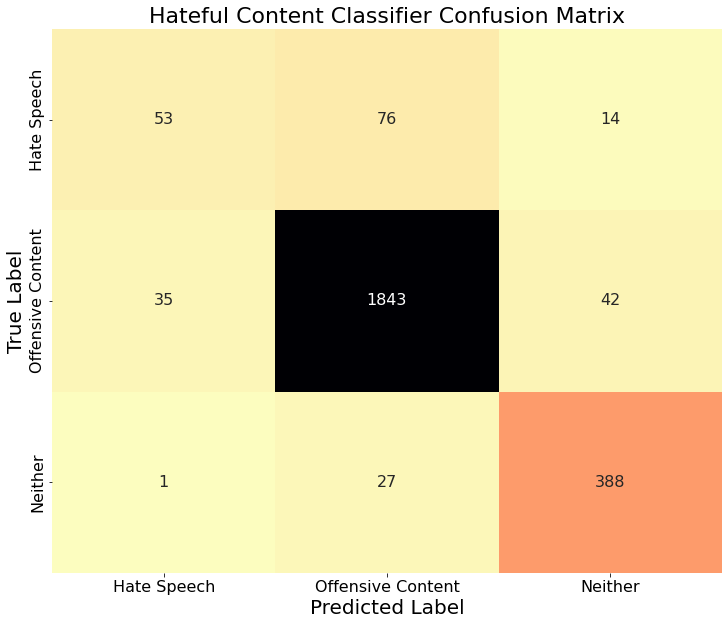

In [128]:
import seaborn as sns

# Make our plot bigger
plt.figure(figsize=(12, 10))

# Class names
tick_labels = ['Hate Speech', 'Offensive Content', 'Neither']

# Use seaborn's heatmap to plot our confusion matrix
ax = sns.heatmap(cm,
                 annot=True,
                 annot_kws={'fontsize': 16},
                 fmt='',
                 xticklabels=tick_labels,
                 yticklabels=tick_labels,
                 cmap=sns.color_palette("magma_r", as_cmap=True),
                 cbar=False,
                )

# Label our graph
ax.set_title('Hateful Content Classifier Confusion Matrix', fontsize=22)
ax.set_xlabel('Predicted Label', fontsize=20)
ax.set_ylabel('True Label', fontsize=20)
ax.tick_params(labelsize=16)

This is pretty helpful since it shows us where our model struggles. Our model performs poorly when classifying hate speech. In particular it seems to classify hate speech as offensive content more often than it does classify it as hate speech. The authors of this dataset built their own classifier that is described in the paper that accompanied the dataset, and in that paper their classifier also struggles with classifying hate speech.

Let us try to get concrete numbers on how our model performs on classifying hate speech. We can get precision, recall, and f1 scores for each class by setting the averaging strategy to None. This will give us an array of scores for each class. They will be in this format:

`['hate' score, 'offensive' score, 'neither' score]`

In [129]:
# Get the scores for each class by setting averaging strategy to None
accuracy, precision_scores, recall_scores, f1_scores = evaluate_keras_classifier(lstm_model,
                                                                                 davidson_seq_test,
                                                                                 y_test,
                                                                                 print_results=False,
                                                                                 averaging_strategy=None)

In [130]:
accuracy

0.9213392496974586

We get a high accuracy but we are not relying on accuracy as a useful metric for this dataset.

In [131]:
precision_scores

array([0.59550562, 0.94707091, 0.87387387])

In [132]:
recall_scores

array([0.37062937, 0.95989583, 0.93269231])

In [133]:
f1_scores

array([0.45689655, 0.95344025, 0.90232558])

The precision and recall scores for the hate class are far lower than the scores for the 'offensive' and 'neither' classes. This is similar to what the researchers experienced with their classifier, except that in their classifier the recall was higher than precision. With our classifier the opposite is true. For this problem recall is more important than precision. The f1 score of the hate class is similarly poor in comparison to the other classes.

For reference these are the scores of Davidson et al.'s classifier on the 'hate' class compared to mine:

| Metric    | Davidson Classifier | My Classifier   |
| --------- | -------- | ---- |
| Precision | 0.44     | 0.60 |
| Recall    | 0.61     | 0.37 |
| F1 Score  | 0.51     | 0.46 |



So why are the scores on the hate class low? Well there are two reasons:

First, there is not much hate speech data in this dataset. As we saw in the beginning of this notebook the hate speech class only makes up 6% of this dataset. So one possibility is that our model did not have enough data to learn what hate speech actually is. Another possibility is simply the nature of this problem. Hate speech is not a very well-defined concept, something that is considered hateful to somebody might not be to somebody else, which creates this ambiguity that does not translate well to machine learning models.

So after all this work how do we know if our model is any good? If we wanted to sum it up with one metric we can look at the weighted F1 score of our model's predictions on the test set. Remember, the `weighted` averaging strategy takes into account class imbalance.

In [134]:
evaluate_keras_classifier(lstm_model,
                          davidson_seq_test,
                          y_test,
                          averaging_strategy='weighted')

Accuracy:  0.9213392496974586
Precision:  0.9145078624930217
Recall:  0.9213392496974586
F1 Score:  0.9162198166715908


We end up with a pretty good score on this dataset, but of course there is always room for improvement.

## Conclusion

Overall, I am quite pleased with the classifier that I built in this notebook. I wanted to also try to train a classifier on a foreign language hate speech dataset but I did not have time to do so. Classifiers like this one are being used to enforce the terms of service of a community or social media website, and there is a need to improve them, particularly for languages other than English. The techniques used in this notebook are not domain specific and can be applied to any text classification task like spam detection, article categorization, sentiment analysis, and fake news detection.

I cannot imagine building a classifier like this in another language, not because of any language-specific features that python has but because of the large amount of open-source libraries available for machine learning and natural language processing. The Jupyter notebook environment made the process of building this classifier a lot easier due to the interactive nature of it. I have looked at both shallow and deep learning models, and have used different methods to represent the text data, but I have not used state of the art transformer architectures like BERT, mostly because I do not understand them well enough. These state of the art methods have received a lot of attention recently for their performance on benchmark tasks so I wouldn't be surprised if they do well on this particular dataset.

### References


1. https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/

2. https://www.statista.com/statistics/264810/number-of-monthly-active-facebook-users-worldwide/

3. https://www.forbes.com/sites/johnkoetsier/2020/06/09/300000-facebook-content-moderation-mistakes-daily-report-says/?sh=2e15774d54d0

4. https://www.forbes.com/sites/traversmark/2020/03/21/facebook-spreads-fake-news-faster-than-any-other-social-website-according-to-new-research/

5. https://hate-alert.github.io/

6. https://apnews.com/article/technology-business-middle-east-religion-europe-a38da3ccd40ffae7e4caa450c374f796